# Multi-modal eval: Image resolution

`Multi-modal slide decks` is a public dataset that contains a dataset of question-answer pairs from slide decks with visual content.

The question-answer pairs are derived from the visual content in the decks, testing the ability of RAG to perform visual reasoning.

GPT-4 can be used to answer questions based upon visual slide content, but [image resolution](https://community.openai.com/t/400-errors-on-gpt-vision-api-since-today/534538/16) is a question:

* Higher resolution costs more tokens, but also leads to flakiness from the API (BadRequestErrors)
* Lower resolution reduces costs and errors, but sacrifices performance

## Pre-requisites

In [ ]:
# %pip install -U langchain langsmith langchain_benchmarks
# %pip install -U openai chromadb pypdfium2 open-clip-torch pillow

In [ ]:
import os
import getpass

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
env_vars = ["LANGCHAIN_API_KEY", "OPENAI_API_KEY"]
for var in env_vars:
    if var not in os.environ:
        os.environ[var] = getpass.getpass(prompt=f"Enter your {var}: ")

## Dataset

We can browse the available LangChain benchmark datasets for retrieval.

In [1]:
from langchain_benchmarks import clone_public_dataset, registry

registry = registry.filter(Type="RetrievalTask")

In [2]:
task = registry["Multi-modal slide decks"]

In [3]:
clone_public_dataset(task.dataset_id, dataset_name=task.name)

Dataset Multi-modal slide decks already exists. Skipping.
You can access the dataset at https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/cd8e425b-5769-4b5e-a784-cbf8e2d72c74.


In [3]:
from langchain_benchmarks.rag.tasks.multi_modal_slide_decks import get_file_names

file_names = list(get_file_names())  # PosixPath

## RAG challenge

For each presentation, extract an image for each slide.

* The pdf presentation has resolution of 960 × 540 pixels.
* When we render each page into a PIL image with a scale factor of 1, the resulting image will also be 960x540 pixel.

In [5]:
import base64
import io
import os
import uuid
from io import BytesIO
from pathlib import Path

from PIL import Image
import pypdfium2 as pdfium

from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.schema.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma


def get_images(file):
    """
    Get PIL images from PDF pages and save them to a specified directory
    :param file: Path to file
    :return: A list of PIL images
    """

    # Get presentation
    pdf = pdfium.PdfDocument(file)
    n_pages = len(pdf)

    # Get images
    pil_images = []
    print(f"Extracting {n_pages} images for {file.name}")
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        bitmap = page.render(scale=1, rotation=0, crop=(0, 0, 0, 0))
        pil_image = bitmap.to_pil()
        pil_images.append(pil_image)
    return pil_images


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string

    :param base64_string: Base64 string
    :param size: Image size
    :return: Re-sized Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def convert_to_base64(pil_image, size):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :param size: Tuple w/ img size
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    img_str = resize_base64_image(img_str, size=size)
    return img_str


def image_summarize(img_base64, prompt, llm):
    """
    Make image summary

    :param img_base64: Base64 encoded string for image
    :param prompt: Text prompt for summarizatiomn
    :return: Image summarization prompt

    """

    if llm == "gpt4v":
        chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)
    elif llm == "gemini":
        chat = ChatGoogleGenerativeAI(model="gemini-pro-vision")
    elif llm == "ollama":
        chat = Ollama(
            model="llava",
            callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
        )

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(img_base64_list, llm):
    """
    Generate summaries for images

    :param img_base64_list: Base64 encoded images
    :param llm: LLM
    :return: List of image summaries and processed images
    """

    # Store image summaries
    image_summaries = []
    processed_images = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply summarization to images
    for i, base64_image in enumerate(img_base64_list):
        try:
            image_summaries.append(image_summarize(base64_image, prompt, llm))
            processed_images.append(base64_image)
        except Exception as e:
            print(f"Error with image {i+1}: {e}")

    return image_summaries, processed_images


def create_multi_vector_retriever(vectorstore, image_summaries, images):
    """
    Create retriever that indexes summaries, but returns raw images or texts

    :param vectorstore: Vectorstore to store embedded image sumamries
    :param image_summaries: Image summaries
    :param images: Base64 encoded images
    :return: Retriever
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    add_documents(retriever, image_summaries, images)

    return retriever


def prepare_images(docs):
    """
    Prepare iamges for prompt

    :param docs: A list of base64-encoded images from retriever.
    :return: Dict containing a list of base64-encoded strings.
    """
    b64_images = []
    for doc in docs:
        if isinstance(doc, Document):
            doc = doc.page_content
        b64_images.append(doc)
    return {"images": b64_images}


def img_prompt_func(data_dict, num_images=2):
    """
    GPT-4V prompt for image analysis.

    :param data_dict: A dict with images and a user-provided question.
    :param num_images: Number of images to include in the prompt.
    :return: A list containing message objects for each image and the text prompt.
    """
    messages = []
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"][:num_images]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    text_message = {
        "type": "text",
        "text": (
            "You are an analyst tasked with answering questions about visual content.\n"
            "You will be give a set of image(s) from a slide deck / presentation.\n"
            "Use this information to answer the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever, llm):
    """
    Multi-modal RAG chain
    :param retriever: Retriever
    :param llm: LLM

    """

    # Multi-modal LLM
    if llm == "gpt4v":
        model = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)
    elif llm == "gemini":
        model = ChatGoogleGenerativeAI(model="gemini-pro-vision")

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(prepare_images),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [ ]:
# Images
images = []
for fi in file_names:
    images.extend(get_images(fi))

# Experiment configurations
experiment_configs = [
    # GPT-4V Configurations
    ((864, 486), "gpt4v-864-486", "gpt4v", "gpt4v"),
    ((768, 432), "gpt4v-768-432", "gpt4v", "gpt4v"),
    ((672, 378), "gpt4v-672-378", "gpt4v", "gpt4v"),
    ((576, 324), "gpt4v-576-324", "gpt4v", "gpt4v"),
    ((480, 270), "gpt4v-480-270", "gpt4v", "gpt4v"),
    ((384, 216), "gpt4v-384-216", "gpt4v", "gpt4v"),
    ((288, 162), "gpt4v-288-162", "gpt4v", "gpt4v"),
    ((192, 108), "gpt4v-192-108", "gpt4v", "gpt4v"),
    ((960, 540), "gpt4v-960-540", "gpt4v", "gpt4v"),
    """
    # Gemini Configurations
    ((864, 486), "gemini-864-486", "gemini", "gemini"),
    ((768, 432), "gemini-768-432", "gemini", "gemini"),
    ((672, 378), "gemini-672-378", "gemini", "gemini"),
    ((576, 324), "gemini-576-324", "gemini", "gemini"),
    ((480, 270), "gemini-480-270", "gemini", "gemini"),
    ((384, 216), "gemini-384-216", "gemini", "gemini"),
    ((288, 162), "gemini-288-162", "gemini", "gemini"),
    ((192, 108), "gemini-192-108", "gemini", "gemini"),
    ((960, 540), "gemini-960-540", "gemini", "gemini"),
    """,
]

stor_chain = {}
for img_resolution, expt, summary_llm, synthesis_llm in experiment_configs:
    # Base64 strings
    images_base_64 = [convert_to_base64(i, img_resolution) for i in images]

    # Image summaries
    image_summaries, images_base_64_processed = generate_img_summaries(
        images_base_64, summary_llm
    )

    # Vectorstore o index the summaries
    vectorstore = Chroma(collection_name=expt, embedding_function=OpenAIEmbeddings())

    # Create retriever
    retriever = create_multi_vector_retriever(
        vectorstore,
        image_summaries,
        images_base_64_processed,
    )

    stor_chain[expt] = multi_modal_rag_chain(retriever, synthesis_llm)

## Eval

Run evaluation on our dataset:

* `task.name` is the dataset of QA pairs that we cloned
* `eval_config` specifies the [LangSmith evaluator](https://docs.smith.langchain.com/evaluation/evaluator-implementations#correctness-qa-evaluation) for our dataset, which will use GPT-4 as a grader
* The grader will evaluate the chain-generated answer to each question relative to ground truth

In [ ]:
import uuid

from langchain.smith import RunEvalConfig
from langsmith.client import Client

# Evaluator configuration
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
"""
chain_map = {
    # GPT-4V Configurations
    "gpt4v-864-486": stor_chain["gpt4v-864-486"],
    "gpt4v-768-432": stor_chain["gpt4v-768-432"],
    "gpt4v-672-378": stor_chain["gpt4v-672-378"],
    "gpt4v-576-324": stor_chain["gpt4v-576-324"],
    "gpt4v-480-270": stor_chain["gpt4v-480-270"],
    "gpt4v-384-216": stor_chain["gpt4v-384-216"],
    "gpt4v-288-162": stor_chain["gpt4v-288-162"],
    "gpt4v-192-108": stor_chain["gpt4v-192-108"],
    "gpt4v-960-540": stor_chain["gpt4v-960-540"],
    # Gemini Configurations
    "gemini-864-486": stor_chain["gemini-864-486"],
    "gemini-768-432": stor_chain["gemini-768-432"],
    "gemini-672-378": stor_chain["gemini-672-378"],
    "gemini-576-324": stor_chain["gemini-576-324"],
    "gemini-480-270": stor_chain["gemini-480-270"],
    "gemini-384-216": stor_chain["gemini-384-216"],
    "gemini-288-162": stor_chain["gemini-288-162"],
    "gemini-192-108": stor_chain["gemini-192-108"],
    "gemini-960-540": stor_chain["gemini-960-540"],
}
"""

chain_map = {
    # GPT-4V Configurations
    "gpt4v-864-486": stor_chain["gpt4v-864-486"],
    "gpt4v-768-432": stor_chain["gpt4v-768-432"],
    "gpt4v-672-378": stor_chain["gpt4v-672-378"],
    "gpt4v-576-324": stor_chain["gpt4v-576-324"],
    "gpt4v-480-270": stor_chain["gpt4v-480-270"],
    "gpt4v-384-216": stor_chain["gpt4v-384-216"],
    "gpt4v-288-162": stor_chain["gpt4v-288-162"],
    "gpt4v-192-108": stor_chain["gpt4v-192-108"],
    "gpt4v-960-540": stor_chain["gpt4v-960-540"],
}

# Run evaluation
run_id = uuid.uuid4().hex[:4]
test_runs = {}
for project_name, chain in chain_map.items():
    test_runs[project_name] = client.run_on_dataset(
        dataset_name=task.name,
        llm_or_chain_factory=lambda: (lambda x: x["Question"]) | chain,
        evaluation=eval_config,
        verbose=True,
        project_name=f"{project_name}-{run_id}",
        project_metadata={"chain": project_name},
    )

## Results

[Here](https://docs.google.com/spreadsheets/d/1X1Id057VkGdlS3jwc4_TDFO1GfEiKLTLzskd9FRQrvM/edit?usp=sharing) are the combined results:

* We run the above 3 times

I save and read in the results, `gpt4v_gemini_eval_121423.csv`. 

Then, we can blot the counts of correct answers wrt resolution for each LLM.

In [167]:
import pandas as pd
import matplotlib.pyplot as plt


def group_standard_error(group):
    # The number of experiments is the number of rows in each group
    # Each experiment consists of 10 questions
    total_trials = len(group) * 10
    std_errors = {}
    for column in ["Failures", "Correct", "Incorrect"]:
        # The sum of values in each column for the group represents the number of occurrences
        occurrences = group[column].sum()
        # The fraction is the sum of occurrences divided by the number of trials times the number of questions per trial
        fraction = occurrences / total_trials
        # The standard error is then calculated with the correct total_trials
        std_errors[column] = (fraction * (1 - fraction) / total_trials) ** 0.5
    return pd.Series(std_errors)


# Read
df = pd.read_csv("/Users/rlm/Desktop/gpt4v_gemini_eval_121423.csv")

# Variability of the proportion of 'Failures', 'Correct', 'Incorrect' across the total trials
std_errors = df.groupby(["LLM", "Resolution"]).apply(group_standard_error)

# Total number of questions per experiment
df["Total"] = df["Failures"] + df["Incorrect"] + df["Correct"]

# Calculate the fractions for each experiment
df["Fraction_Failures"] = df["Failures"] / df["Total"]
df["Fraction_Incorrect"] = df["Incorrect"] / df["Total"]
df["Fraction_Correct"] = df["Correct"] / df["Total"]

# Mean of fractions for each LLM + Resolution pair
mean_values = (
    df.groupby(["LLM", "Resolution"])
    .agg(
        {
            "Fraction_Failures": "mean",
            "Fraction_Incorrect": "mean",
            "Fraction_Correct": "mean",
        }
    )
    .copy()
)

mean_values.rename(
    columns={
        "Fraction_Failures": "Failures",
        "Fraction_Correct": "Correct",
        "Fraction_Incorrect": "Incorrect",
    },
    inplace=True,
)

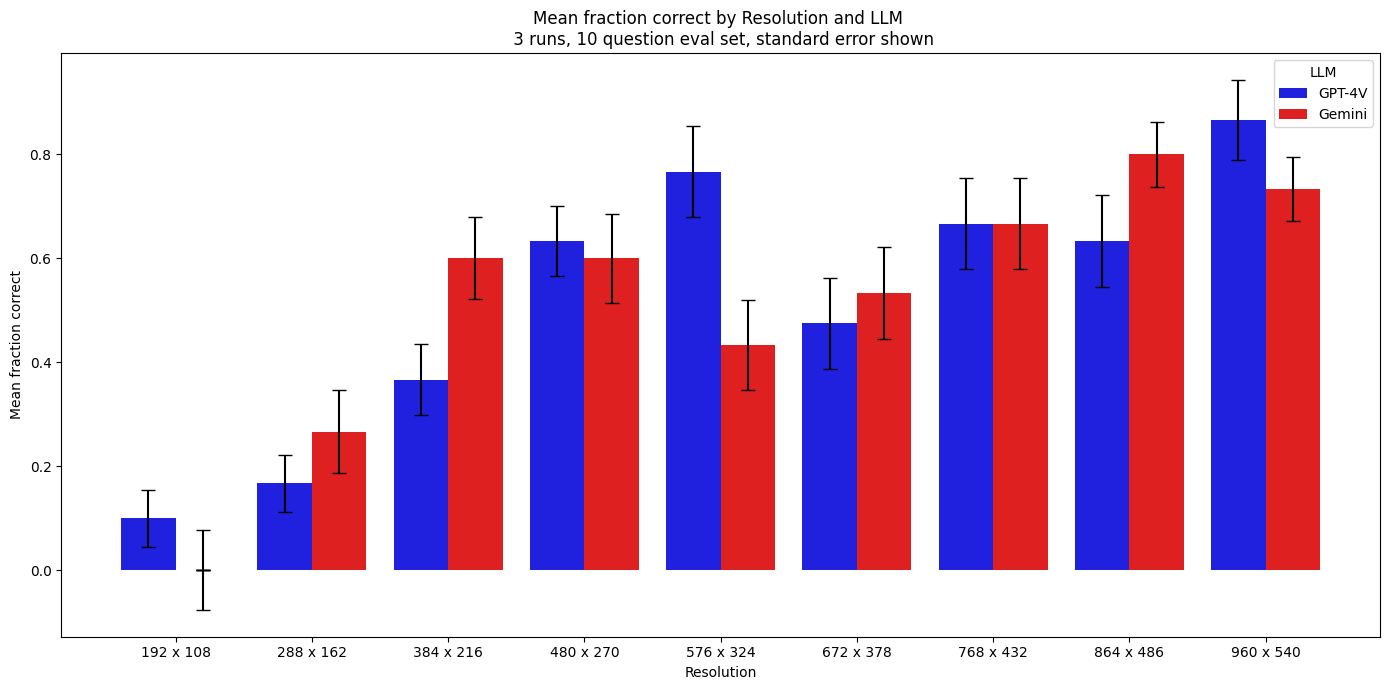

In [169]:
import seaborn as sns


def plt_bar_graph(df, field):
    plt.figure(figsize=(14, 7))
    barplot = sns.barplot(
        x="Resolution",
        y=field,
        hue="LLM",
        data=df,
        capsize=0.1,
        palette={"GPT-4V": "blue", "Gemini": "red"},
    )

    # Find the total number of bars for each resolution group and their width
    n_bars = len(correct_means_and_errors["LLM"].unique())
    bar_width = barplot.patches[0].get_width()

    # Iterate over the bars
    for i, bar in enumerate(barplot.patches):
        # Calculate the index of the standard error corresponding to the bar
        std_error_index = i // n_bars
        # Calculate the error from the 'Std error' column
        error = correct_means_and_errors["Std error"].iloc[std_error_index]
        # Plot the error bars
        barplot.errorbar(
            bar.get_x() + bar_width / 2,  # X position is the center of the bar
            bar.get_height(),  # Y position is the height of the bar
            yerr=error,  # Y error is the standard error
            fmt="none",  # No connecting lines
            color="black",  # Color of the error bars
            capsize=5,  # Width of the caps on the error bars
        )

    plt.title(
        f"{field} by Resolution and LLM \n 3 runs, 10 question eval set, standard error shown"
    )
    plt.xlabel("Resolution")
    plt.ylabel(field)
    plt.legend(title="LLM")
    plt.tight_layout()
    plt.show()


# Combine to plot
correct_means_and_errors = pd.concat(
    [mean_values["Correct"], std_errors["Correct"]], axis=1
)
correct_means_and_errors.columns = ["Mean fraction correct", "Std error"]
correct_means_and_errors.reset_index(inplace=True)
plt_bar_graph(correct_means_and_errors, "Mean fraction correct")

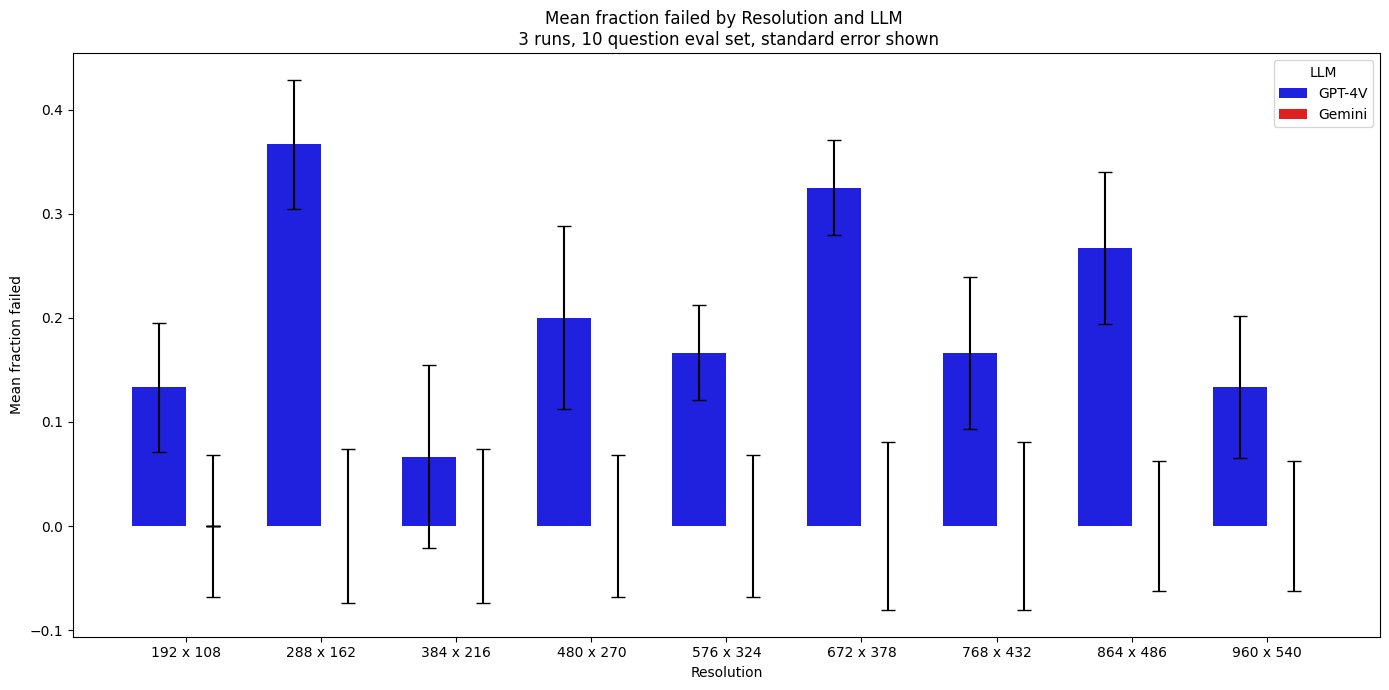

In [170]:
# Combine to plot
correct_means_and_errors = pd.concat(
    [mean_values["Failures"], std_errors["Failures"]], axis=1
)
correct_means_and_errors.columns = ["Mean fraction failed", "Std error"]
correct_means_and_errors.reset_index(inplace=True)
plt_bar_graph(correct_means_and_errors, "Mean fraction failed")

## Extraction challenge

I created an eval set for extraction using one of the slides in the deck, which contains lots of nested statistics.

In [6]:
# Images
images = []
for fi in file_names:
    images.extend(get_images(fi))

Extracting 30 images for DDOG_Q3_earnings_deck.pdf


We can set up the code and view the slide of interest.


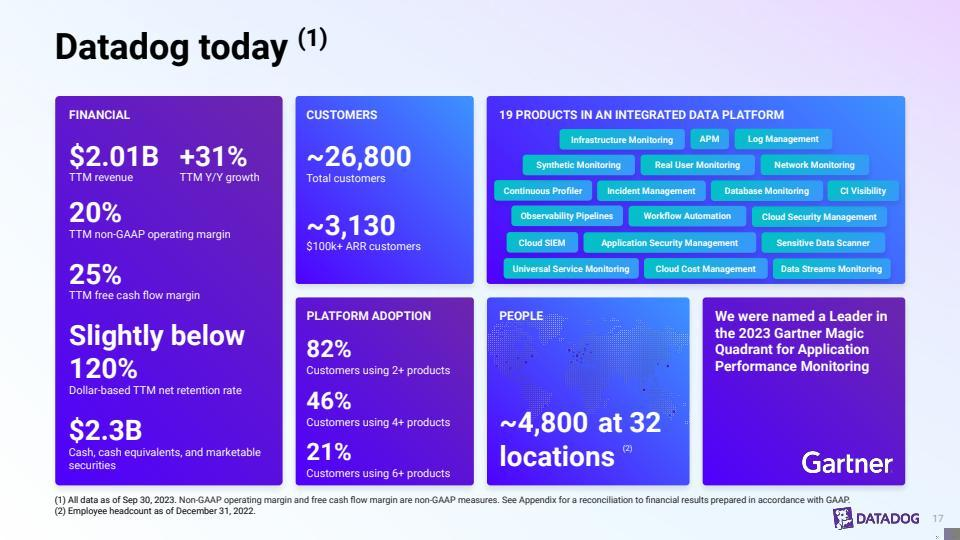

In [23]:
from langchain.chat_models import ChatOllama
from IPython.display import HTML, display
from PIL import Image


def img_prompt_func(data_dict):
    """
    GPT-4V prompt for image analysis.

    :param data_dict: A dict with images and a user-provided question.
    :return: A list containing message objects for each image and the text prompt.
    """
    messages = []
    """ 
    image_message = {
        "type": "image_url",
        "image_url": {"url": f"data:image/jpeg;base64,{data_dict['image']}"},
    }
    """
    image_message = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{data_dict['image']}",
    }
    text_message = {
        "type": "text",
        "text": (
            "You are an analyst tasked with answering questions about visual content.\n"
            "You will be give a set of image(s) from a slide deck / presentation.\n"
            "Use this information to answer the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
        ),
    }
    messages.append(image_message)
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_qa_chain(llm, image):
    """
    Multi-modal RAG chain
    :param retriever: Retriever
    :param llm: LLM

    """

    # Multi-modal LLM
    if llm == "gpt4v":
        model = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)
    elif llm == "gemini":
        model = ChatGoogleGenerativeAI(model="gemini-pro-vision")
    elif llm == "llava":
        model = ChatOllama(model="llava:13b-v1.5-q4_K_S", temperature=0)

    # RAG pipeline
    chain = (
        {
            "image": lambda _: image,
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


# Choose image
i = 16
test_image = images[i]
image_base_64 = convert_to_base64(test_image, (960, 540))
plt_img_base64(image_base_64)

Create a simple QA chain for various image resolutions and multi-modal LLMs.

In [26]:
experiment_configs = [
    # GPT-4V Configurations
    ((960, 540), "gpt4v-960-540-res", "gpt4v", "gpt4v"),
    ((672, 378), "gpt4v-672-378-res", "gpt4v", "gpt4v"),
    ((480, 270), "gpt4v-480-270-res", "gpt4v", "gpt4v"),
    ((288, 162), "gpt4v-288-162-res", "gpt4v", "gpt4v"),
    ((192, 108), "gpt4v-192-108-res", "gpt4v", "gpt4v"),
    # Gemini Configurations
    ((960, 540), "gemini-960-540-res", "gemini", "gemini"),
    ((672, 378), "gemini-672-378-res", "gemini", "gemini"),
    ((480, 270), "gemini-480-270-res", "gemini", "gemini"),
    ((288, 162), "gemini-288-162-res", "gemini", "gemini"),
    ((192, 108), "gemini-192-108-res", "gemini", "gemini"),
    # LLaVA Configurations
    ((960, 540), "llava-960-540-res", "llava", "llava"),
    ((672, 378), "llava-672-378-res", "llava", "llava"),
    ((480, 270), "llava-480-270-res", "llava", "llava"),
    ((288, 162), "llava-288-162-res", "llava", "llava"),
    ((192, 108), "llava-192-108-res", "llava", "llava"),
]

stor_chain_res = {}
for img_resolution, expt, synthesis_llm, __ in experiment_configs:
    image_base_64 = convert_to_base64(test_image, img_resolution)
    stor_chain_res[expt] = multi_modal_qa_chain(synthesis_llm, image_base_64)

We have a small eval set of 8 questions [here](https://docs.google.com/spreadsheets/d/1jPmsBwplDGXVOJJuj3YyHFqzrzTZYyr15FY3TFoQt9A/edit?usp=sharing).

Simply import the csv into LangSmith to create your dataset, `Multi Modal Extraction`.

When then specify it below, `dataset_name="Multi Modal Extraction"`.

In [ ]:
import uuid

from langchain.smith import RunEvalConfig
from langsmith.client import Client

# Evaluator configuration
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
chain_map = {
    # GPT-4V Configurations
    "gpt4v-960-540-res": stor_chain_res["gpt4v-960-540-res"],
    "gpt4v-672-378-res": stor_chain_res["gpt4v-672-378-res"],
    "gpt4v-480-270-res": stor_chain_res["gpt4v-480-270-res"],
    "gpt4v-288-162-res": stor_chain_res["gpt4v-288-162-res"],
    "gpt4v-192-108-res": stor_chain_res["gpt4v-192-108-res"],
    # Gemini Configurations
    "gemini-960-540-res": stor_chain_res["gemini-960-540-res"],
    "gemini-672-378-res": stor_chain_res["gemini-672-378-res"],
    "gemini-480-270-res": stor_chain_res["gemini-480-270-res"],
    "gemini-288-162-res": stor_chain_res["gemini-288-162-res"],
    "gemini-192-108-res": stor_chain_res["gemini-192-108-res"],
    # LLaVA Configurations
    "llava-960-540-res": stor_chain_res["llava-960-540-res"],
    "llava-672-378-res": stor_chain_res["llava-672-378-res"],
    "llava-480-270-res": stor_chain_res["llava-480-270-res"],
    "llava-288-162-res": stor_chain_res["llava-288-162-res"],
    "llava-192-108-res": stor_chain_res["llava-192-108-res"],
}

chain_map = {
    # GPT-4V Configurations
    "gpt4v-480-270-res": stor_chain_res["gpt4v-480-270-res"],
}

# Run evaluation
run_id = uuid.uuid4().hex[:4]
test_runs = {}
for project_name, chain in chain_map.items():
    test_runs[project_name] = client.run_on_dataset(
        dataset_name="Multi Modal Extraction",
        llm_or_chain_factory=lambda: (lambda x: x["Question"]) | chain,
        evaluation=eval_config,
        verbose=True,
        project_name=f"{project_name}-{run_id}",
        project_metadata={"chain": project_name},
    )

See the results [here](https://docs.google.com/spreadsheets/d/1jPmsBwplDGXVOJJuj3YyHFqzrzTZYyr15FY3TFoQt9A/edit#gid=250106673): 

* LLaVA suffers for this extraction task
* Gemini and GPT-4V perform similarly

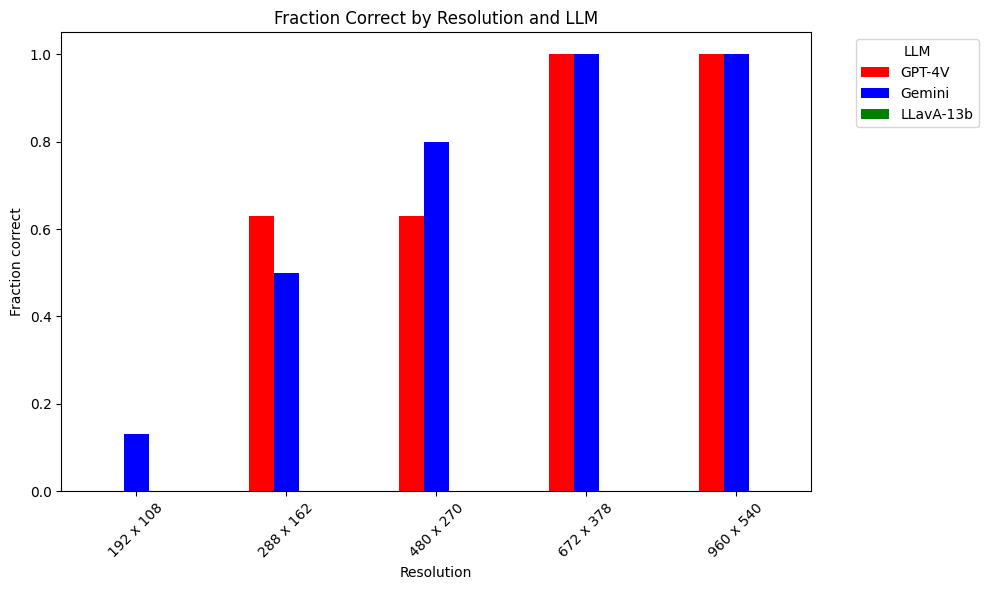

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot the DataFrame
df_pivot = df.pivot(index="Resolution", columns="LLM", values="% Correct")

# Plotting with specified colors
plt.figure(figsize=(10, 6))
df_pivot.plot(kind="bar", color=["r", "b", "g"], ax=plt.gca())
plt.title("Fraction Correct by Resolution and LLM")
plt.xlabel("Resolution")
plt.ylabel("Fraction correct")
plt.xticks(rotation=45)
plt.legend(title="LLM", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()